In [271]:
#%%imports
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
import glob
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import polars as pl
import shutil
import subprocess
import sys


sys.path.append('../../')

from astroLuSt.database_interface import tesscut_interface as aldate
from astroLuSt.datascience import robustpca as aldaro
from astroLuSt.preprocessing import (
    images as alprim,
    photometry as alprph,
)
from astroLuSt.visualization import plotting as alvipg

importlib.reload(aldaro)

<module 'astroLuSt.datascience.robustpca' from '/home/lukas/github/astroLuSt/demos/datascience/../../astroLuSt/datascience/robustpca.py'>

# Get Data

### Generating random matrix with real singular values

In [326]:
def generate_realsv_matrix(
        size:tuple,
        sva_min:float=0, sva_max:float=1
    ) -> np.ndarray:
    """
        - function to generate a matrix with real singular values

        Parameters
        ----------
            - `size`
                - `Tuple[int,int]`
                - size the generated matrix shall have
            - `sva_min`
                - `float`, optional
                - value of the smallest generated singular value
                - the default is `0`
            - `sva_max`
                - `float`, optional
                - value of the largest generated singular value
                - the default is `1`
        
        Raises
        ------

        Returns
        -------
            - `Y`
                - `np.ndarray`
                - a matrix of shape `size` with real eigenvalues
                    - eigenvalues are equidistantly generated (`np.linspace(0,eva_max,min(m,n))[::-1]`)

        Dependencies
        ------------
            - `numpy`
        
        Comments
        --------
    """
    m, n = size

    #singular values
    eva = np.linspace(sva_min,sva_max,min(m,n))[::-1]
    S = np.zeros((m,n))
    np.fill_diagonal(S, eva)

    #random orthogonal matrices
    U =  np.linalg.qr(np.random.randint(0, 5, size=(m,m)))[0]
    Vh = np.linalg.qr(np.random.randint(0, 5, size=(n,n)))[0]
    # print(U.shape, S.shape, Vh.shape)

    Y = (U@S)@Vh

    # #testing
    # _, S_, _ = np.linalg.svd(Y, full_matrices=False)
    # # print(eva)
    # print(S_)

    return Y



### Sample from [DAVIS](https://davischallenge.org/davis2017/code.html) dataset

../_data/davis_aerobatics.npy already downloaded


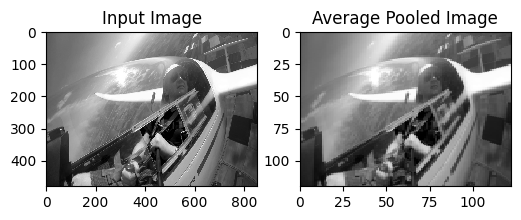

In [119]:
davis2load = "aerobatics"
davisfname = f"../_data/davis_{davis2load}.npy"
#download data if not already done
if davisfname not in glob.glob("../_data/*"):
    print(f"{davisfname} not found: downloading")
    
    #download data
    subprocess.call(["bash","./get_davis.sh"])

    #load data
    fnames = sorted(glob.glob(f"../_data/davis/DAVIS/JPEGImages/480p/{davis2load}/*.jpg"))
    X = np.array([Image.open(fn) for fn in fnames])

    ##convert to greyscale
    X = X.mean(axis=-1)/255
    np.save(davisfname, X)

    #remove downloaded data
    shutil.rmtree("../_data/davis")
    os.remove("../_data/davis.zip")
else:
    print(f"{davisfname} already downloaded")
    X = np.load(davisfname)


#average pool image for lower dimensionality
# for i in range(1,20): print(i, X.shape[2]/i)
I2P = alprim.Images2Patches(int(X.shape[2]/7),int(X.shape[1]/4))
I2P.fit(X)
X_p = I2P.transform()
X_p = np.mean(X_p, axis=(3,4))

#testplot
fig = plt.figure(figsize=(6,2))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_title('Input Image')
ax2.set_title('Average Pooled Image')
ax1.pcolormesh(X[0], cmap='gray')
ax2.pcolormesh(X_p[0], cmap='gray')
ax1.invert_yaxis()
ax2.invert_yaxis()


plt.show()


### Astronomical Observations

In [120]:
importlib.reload(aldate)

#define targets
df_targets = pl.from_dicts([
    dict(coords=SkyCoord("19 25 27.9129605304 +42 47 03.693258204", frame="icrs", unit=(u.hourangle, u.deg)), name="RRLyr", sectors=[14,40],   period=0.5667732268824381),
    dict(coords=SkyCoord("14 16 36.5814789480 +42 21 35.712985824", frame="icrs", unit=(u.hourangle, u.deg)), name="TVBoo", sectors=[1,16,23], period=0.3125589785657776),
])
display(df_targets)


#instantiate
TCI = aldate.TESScut_Interface(
    n_jobs=5,
    redownload=False,
    sleep=.5,
    verbose=1,
)

#download
hdulists = TCI.download(
    coordinates=df_targets["coords"],
    sectors=df_targets["sectors"],
    targ_ids=df_targets["name"],
    combine_sectors=True,       #combine all downloaded sectors into one array
    ffi_header_keys=["TELESCOP"],
    prim_header_keys=["TELESCOP", "INSTRUME"],
    col_keys=["SECTOR","EXPOSURE"],
    n_jobs=None,
    savedir=f"../_data/",
    # savedir=None,             #don't save
    filenames=None,             #autogenerate
    verbose=None,
    parallel_kwargs=dict(backend="threading"),
    get_cutouts_kwargs=dict(size=[15,20], product="SPOC"),
)


coords,name,sectors,period
object,str,list[i64],f64
"<SkyCoord (ICRS): (ra, dec) in deg (291.366304, 42.78435924)>","""RRLyr""","[14, 40]",0.566773
"<SkyCoord (ICRS): (ra, dec) in deg (214.15242283, 42.35992027)>","""TVBoo""","[1, 16, 23]",0.312559


In [121]:

#in case you already have the files downloaded
hdulists = [fits.open(f'../_data/{name}_cutouts.fits') for name in df_targets['name']]    #load in same order as input dataframe (and hence coords)
print(hdulists)
print(len(hdulists))

tpfs = [hdul[1].data.field('FLUX').copy() for hdul in hdulists]
tpfs_e = [hdul[1].data.field('FLUX_ERR').copy() for hdul in hdulists]
times = [hdul[1].data.field('TIME').copy() for hdul in hdulists]
sectors = [hdul[1].data.field('SECTOR').copy() for hdul in hdulists]

print(tpfs[0].shape, tpfs_e[0].shape)

[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x784537066680>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x784537065de0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x784537066230>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x784537065fc0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x784536f36b00>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x784536f34640>]]
2
(5168, 15, 20) (5168, 15, 20)


# `soft_thresholding()`

(101,)


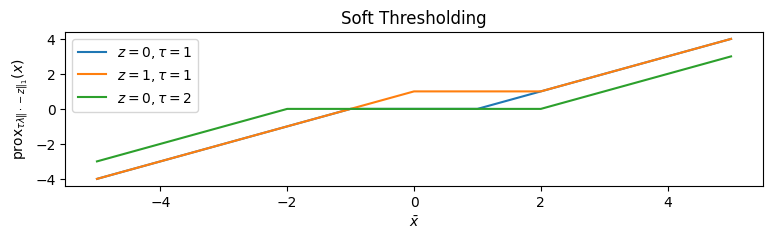

In [327]:
importlib.reload(aldaro)
#visualize soft_thresholding
X = np.linspace(-5,5,101)
M = 1
lbda = 1
tau = 1
print(X.shape)

y  = aldaro.soft_thresholding(xbar=X, z=0, tau=1)
y1 = aldaro.soft_thresholding(xbar=X, z=1, tau=1)
y2 = aldaro.soft_thresholding(xbar=X, z=0, tau=2)

fig = plt.figure(figsize=(9,2))
ax1 = fig.add_subplot(111)
ax1.set_title('Soft Thresholding')
ax1.plot(X, y,  label=r'$z=0, \tau=1$')
ax1.plot(X, y1, label=r'$z=1, \tau=1$')
ax1.plot(X, y2, label=r'$z=0, \tau=2$')
ax1.set_xlabel(r'$\bar x$')
ax1.set_ylabel(r'$\mathrm{prox}_{\tau\lambda\Vert\cdot-z\Vert_1}(x)$')
ax1.legend()
plt.show()

# `svd_shrinkage()`
* used in [RPCA](#robust-pca)
* in the plot below $\mathrm{SVDSH}(Y,\tau)$ refers to singular value thresholding with parameter $\tau$ applied to $Y$

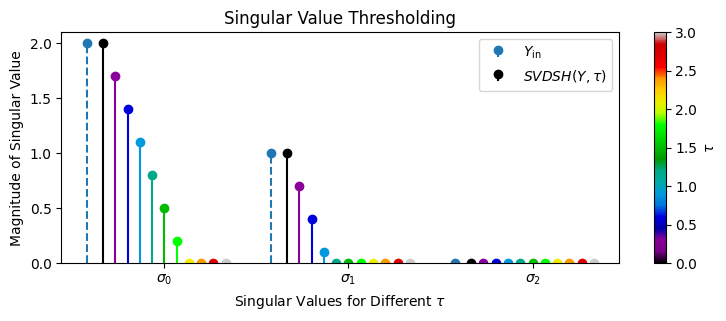

In [354]:
import matplotlib.colors as mcolors

#get input matrix (and eigen values)
Y = generate_realsv_matrix(size=(3,4), sva_min=0, sva_max=2)
_, sva, _ = np.linalg.svd(Y)

#different values for `tau` to be shown
tau2test = np.linspace(0,3,11)
tau_max = np.max(tau2test)


#plotting
fig = plt.figure(figsize=(9,3))
locs = np.linspace(0,tau_max*sva.shape[0], sva.shape[0])    #locations of the stems in the plot
colors = alvipg.generate_colors(tau2test)

ax1 = fig.add_subplot(111, title="Singular Value Thresholding")
ax1.stem(locs-.4, sva, linefmt="--", basefmt="none", label=r"$Y_\mathrm{in}$")  #input
ax1.set_ylim(min(0,np.min(sva)), None)
ax1.set_xticks(np.linspace(0,sva.shape[0]*tau_max, sva.shape[0])+tau_max/2, labels=[r"$\sigma_%i$"%i for i in range(sva.shape[0])])
ax1.set_xlabel(r"Singular Values for Different $\tau$")
ax1.set_ylabel(r"Magnitude of Singular Value")

##try different tau
for idx, tau in enumerate(tau2test):
    Y_tau = aldaro.svd_shrinkage(Y, tau=tau)
    # print(Y_)
    _, S_tau, _ = np.linalg.svd(Y_tau, full_matrices=False)
    # print(tau, S_)
    ml, sl, bl = ax1.stem(locs+tau, S_tau, basefmt="none", label=r"$SVDSH(Y,\tau)$"*(idx==0))
    ml.set_markerfacecolor(colors[idx])
    ml.set_markeredgecolor(colors[idx])
    sl.set_color(colors[idx])
    if idx==0:
        cm = plt.cm.ScalarMappable(norm=mcolors.Normalize(0, tau_max), cmap="nipy_spectral")
        cbar = fig.colorbar(cm, ax=ax1)
        cbar.set_label(r"$\tau$")
ax1.legend()
plt.show()


# `sv_clip()`
* clipping singular values of a matrix

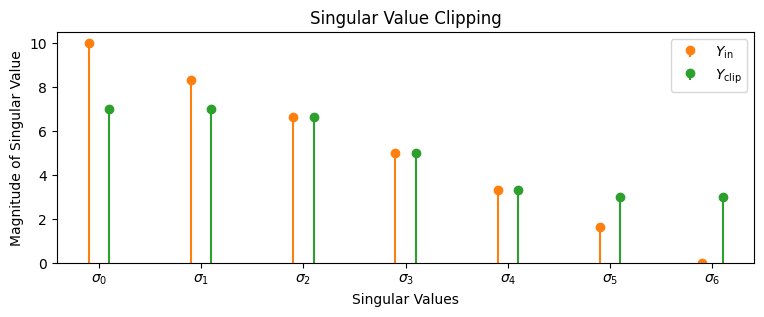

In [356]:
Y = generate_realsv_matrix((7,8), sva_min=0, sva_max=10)    #generate some matrix
_, sva, _ = np.linalg.svd(Y, full_matrices=False)           #get its singular values

Y_clip = aldaro.sv_clip(Y, a_min=3, a_max=7)                #apply clipping
_, sva_clip, _ = np.linalg.svd(Y_clip, full_matrices=False) #get clipped singular values


#plotting
fig = plt.figure(figsize=(9,3))
locs = np.arange(0,sva.shape[0])    #locations of the stems in the plot

ax1 = fig.add_subplot(111, title="Singular Value Clipping")
ax1.stem(locs-.1,    sva,      markerfmt="C1", linefmt="C1", basefmt="none", label=r"$Y_\mathrm{in}$")  #input
ax1.stem(locs+.1, sva_clip, markerfmt="C2", linefmt="C2", basefmt="none", label=r"$Y_\mathrm{clip}$")  #input
ax1.set_ylim(min(0,np.min(sva)), None)

ax1.legend()
ax1.set_xticks(np.arange(sva.shape[0]), labels=[r"$\sigma_%i$"%i for i in range(sva.shape[0])])
ax1.set_xlabel(r"Singular Values")
ax1.set_ylabel(r"Magnitude of Singular Value")

plt.show()



# Robust PCA

## Via CP
* [Chambolle-Pock Algorithm](https://link.springer.com/article/10.1007/s10851-010-0251-1)

INFO(RPCA_CP.fit): Iteration 1 with delta= 0.0e+00, energy= 1.33e+03.
INFO(RPCA_CP.fit): Iteration 2 with delta= 9.4e-03, energy= 1.32e+03.
INFO(RPCA_CP.fit): Iteration 3 with delta= 1.6e-02, energy= 1.30e+03.
INFO(RPCA_CP.fit): Iteration 4 with delta= 1.4e-02, energy= 1.28e+03.
INFO(RPCA_CP.fit): Iteration 5 with delta= 9.2e-03, energy= 1.27e+03.
INFO(RPCA_CP.fit): Iteration 6 with delta= 8.1e-03, energy= 1.26e+03.
INFO(RPCA_CP.fit): Iteration 7 with delta= 7.5e-03, energy= 1.25e+03.
INFO(RPCA_CP.fit): Iteration 8 with delta= 8.1e-03, energy= 1.24e+03.
INFO(RPCA_CP.fit): Iteration 9 with delta= 6.2e-03, energy= 1.23e+03.
INFO(RPCA_CP.fit): Iteration 10 with delta= 5.3e-03, energy= 1.22e+03.
INFO(RPCA_CP.fit): Iteration 11 with delta= 4.2e-03, energy= 1.22e+03.
INFO(RPCA_CP.fit): Iteration 12 with delta= 3.8e-03, energy= 1.21e+03.
INFO(RPCA_CP.fit): Iteration 13 with delta= 3.5e-03, energy= 1.21e+03.
INFO(RPCA_CP.fit): Iteration 14 with delta= 2.2e-03, energy= 1.21e+03.
INFO(RPCA_CP.fi

MovieWriter ffmpeg unavailable; using Pillow instead.


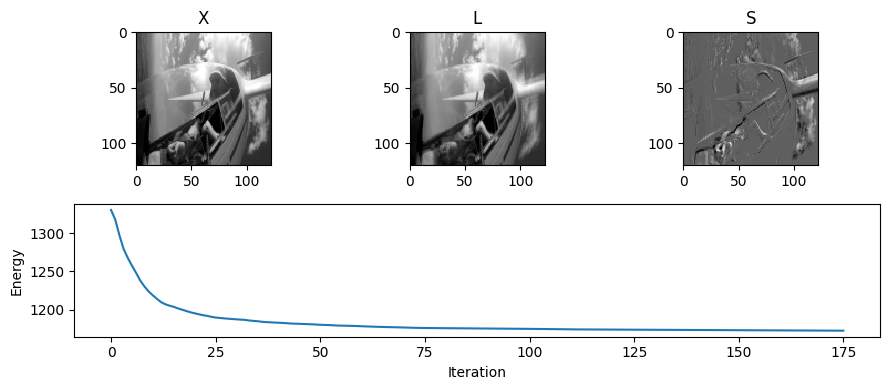

In [ ]:
importlib.reload(aldaro)
RPCA = aldaro.RobustPCA(
    lbda=9e-3,
    tau=100,
    max_iter=500,
    eps=1e-5,
    method='chambolle_pock',
    verbose=3,
)
X_train = X_p       #movie
# X_train = X_p[0]    #image

RPCA.fit(X_train, y=None, L0=None, S0=None, Y0=None)    #init with zeros
L, S = RPCA.transform(X=None, y=None)

fig = plt.figure(figsize=(9,4))
fig, axs, anim = RPCA.plot_result(
    X=X_train,
    L=L, S=S,
    fig=fig,
    animate=True,
    pcolormesh_kwargs=None,
    func_animation_kwargs=dict(repeat=False, frames=range(0,X_train.shape[0],1))  
)
for ax in axs[:-1]:
    ax.invert_yaxis()

fig.savefig(f'../_gfx/rpca_{davis2load}_{RPCA.method}.png')
anim.save(f'../_gfx/rpca_{davis2load}_{RPCA.method}.gif')
plt.show()


## Via ADMM
* [Alternating Direction Method of Multipliers](https://stanford.edu/~boyd/admm.html)

INFO(RPCA_ADMM.fit): Iteration 1 with delta= 0.0e+00, energy= 1.31e+03.
INFO(RPCA_ADMM.fit): Iteration 2 with delta= 2.6e-03, energy= 1.32e+03.
INFO(RPCA_ADMM.fit): Iteration 3 with delta= 3.1e-03, energy= 1.31e+03.
INFO(RPCA_ADMM.fit): Iteration 4 with delta= 3.1e-03, energy= 1.31e+03.
INFO(RPCA_ADMM.fit): Iteration 5 with delta= 3.0e-03, energy= 1.30e+03.
INFO(RPCA_ADMM.fit): Iteration 6 with delta= 3.0e-03, energy= 1.30e+03.
INFO(RPCA_ADMM.fit): Iteration 7 with delta= 2.9e-03, energy= 1.30e+03.
INFO(RPCA_ADMM.fit): Iteration 8 with delta= 2.9e-03, energy= 1.29e+03.
INFO(RPCA_ADMM.fit): Iteration 9 with delta= 2.8e-03, energy= 1.29e+03.
INFO(RPCA_ADMM.fit): Iteration 10 with delta= 2.8e-03, energy= 1.29e+03.
INFO(RPCA_ADMM.fit): Iteration 11 with delta= 2.7e-03, energy= 1.28e+03.
INFO(RPCA_ADMM.fit): Iteration 12 with delta= 2.7e-03, energy= 1.28e+03.
INFO(RPCA_ADMM.fit): Iteration 13 with delta= 2.6e-03, energy= 1.28e+03.
INFO(RPCA_ADMM.fit): Iteration 14 with delta= 2.5e-03, energ

MovieWriter ffmpeg unavailable; using Pillow instead.


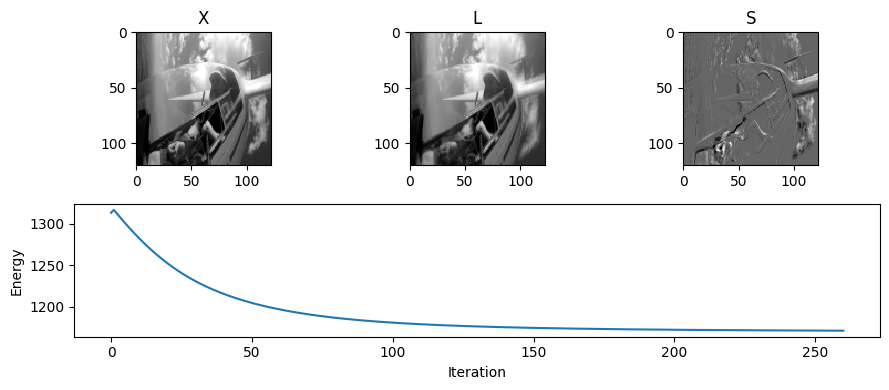

In [107]:
importlib.reload(aldaro)
RPCA = aldaro.RobustPCA(
    lbda=9e-3,
    mu=5,
    max_iter=500,
    eps=1e-5,
    method='admm',
    verbose=3,
)
X_train = X_p       #movie
# X_train = X_p[0]    #image

RPCA.fit(X_train, y=None, L0=None, S0=None, Y0=None)    #init with zeros
L, S = RPCA.transform(X=None, y=None)

fig = plt.figure(figsize=(9,4))
fig, axs, anim = RPCA.plot_result(
    X=X_train,
    L=L, S=S,
    fig=fig,
    animate=True,
    pcolormesh_kwargs=None,
    func_animation_kwargs=dict(repeat=False, frames=range(0,X_train.shape[0],1))  
)
for ax in axs[:-1]:
    ax.invert_yaxis()

fig.savefig(f'../_gfx/rpca_{davis2load}_{RPCA.method}.png')
anim.save(f'../_gfx/rpca_{davis2load}_{RPCA.method}.gif')
plt.show()


## Applied to Astronomical Observations
* Note that for the fist 3 panels in the LCs, no aperture has been applied!

RobustPCA(
    lbda=0.007,
    tau=1000, mu=1.0,
    max_iter=500, eps=1e-05,
    theta=1.0,
    method='chambolle_pock',
    verbose=3,
)
INFO(RPCA_CP.fit): Iteration 1 with delta= 0.0e+00, energy= 9.27e+06.
INFO(RPCA_CP.fit): Iteration 2 with delta= 6.4e-03, energy= 9.21e+06.
INFO(RPCA_CP.fit): Iteration 3 with delta= 6.5e-03, energy= 9.15e+06.
INFO(RPCA_CP.fit): Iteration 4 with delta= 6.5e-03, energy= 9.09e+06.
INFO(RPCA_CP.fit): Iteration 5 with delta= 6.6e-03, energy= 9.03e+06.
INFO(RPCA_CP.fit): Iteration 6 with delta= 6.6e-03, energy= 8.97e+06.
INFO(RPCA_CP.fit): Iteration 7 with delta= 6.6e-03, energy= 8.91e+06.
INFO(RPCA_CP.fit): Iteration 8 with delta= 6.7e-03, energy= 8.85e+06.
INFO(RPCA_CP.fit): Iteration 9 with delta= 6.7e-03, energy= 8.79e+06.
INFO(RPCA_CP.fit): Iteration 10 with delta= 6.8e-03, energy= 8.73e+06.
INFO(RPCA_CP.fit): Iteration 11 with delta= 6.8e-03, energy= 8.67e+06.
INFO(RPCA_CP.fit): Iteration 12 with delta= 6.9e-03, energy= 8.61e+06.
INFO(RPCA_CP.fit):

MovieWriter ffmpeg unavailable; using Pillow instead.


RobustPCA(
    lbda=0.009,
    tau=10000, mu=1.0,
    max_iter=500, eps=1e-05,
    theta=1.0,
    method='chambolle_pock',
    verbose=3,
)
INFO(RPCA_CP.fit): Iteration 1 with delta= 0.0e+00, energy= 2.20e+06.
INFO(RPCA_CP.fit): Iteration 2 with delta= 1.1e-01, energy= 1.95e+06.
INFO(RPCA_CP.fit): Iteration 3 with delta= 5.5e-02, energy= 1.84e+06.
INFO(RPCA_CP.fit): Iteration 4 with delta= 3.8e-02, energy= 1.77e+06.
INFO(RPCA_CP.fit): Iteration 5 with delta= 3.1e-02, energy= 1.72e+06.
INFO(RPCA_CP.fit): Iteration 6 with delta= 2.5e-02, energy= 1.68e+06.
INFO(RPCA_CP.fit): Iteration 7 with delta= 2.2e-02, energy= 1.64e+06.
INFO(RPCA_CP.fit): Iteration 8 with delta= 2.0e-02, energy= 1.61e+06.
INFO(RPCA_CP.fit): Iteration 9 with delta= 1.8e-02, energy= 1.58e+06.
INFO(RPCA_CP.fit): Iteration 10 with delta= 1.7e-02, energy= 1.55e+06.
INFO(RPCA_CP.fit): Iteration 11 with delta= 1.6e-02, energy= 1.53e+06.
INFO(RPCA_CP.fit): Iteration 12 with delta= 1.5e-02, energy= 1.50e+06.
INFO(RPCA_CP.fit)

MovieWriter ffmpeg unavailable; using Pillow instead.


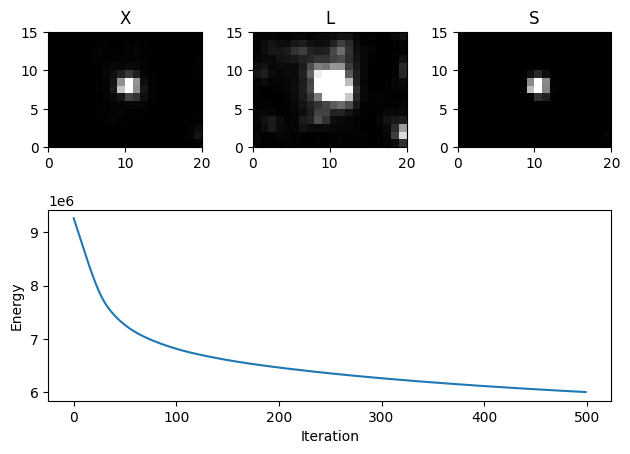

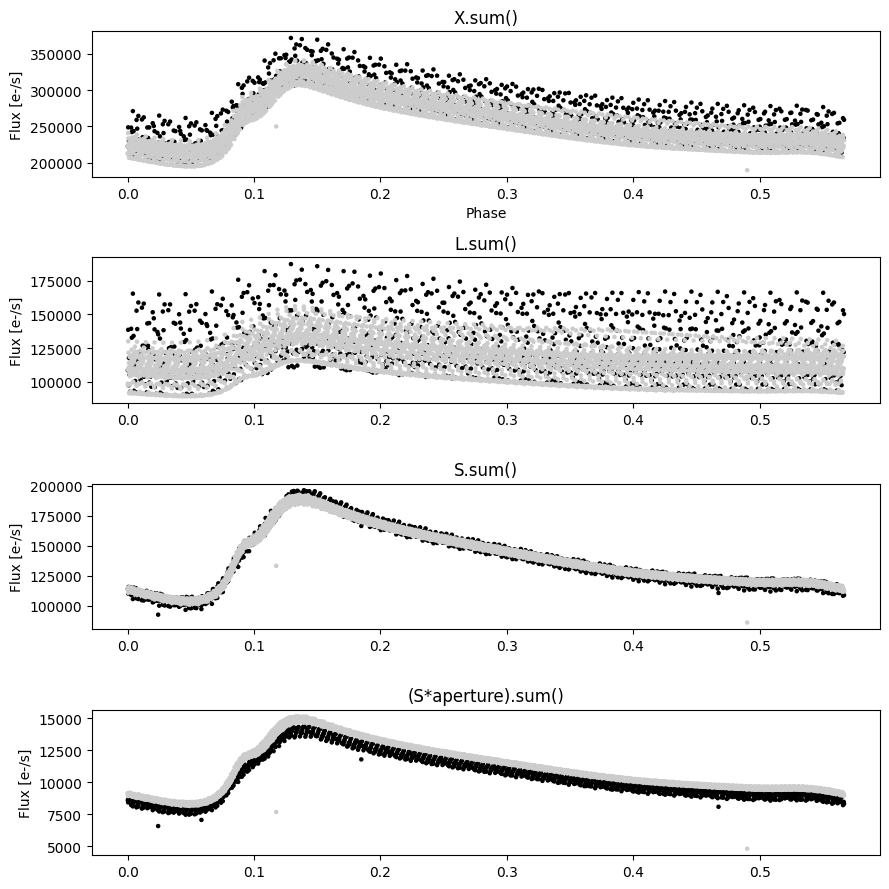

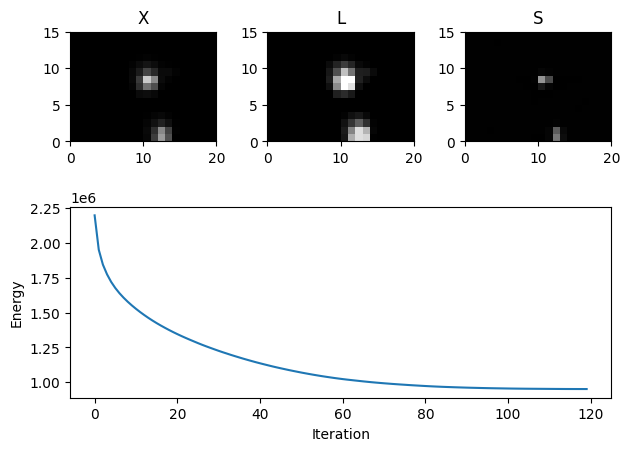

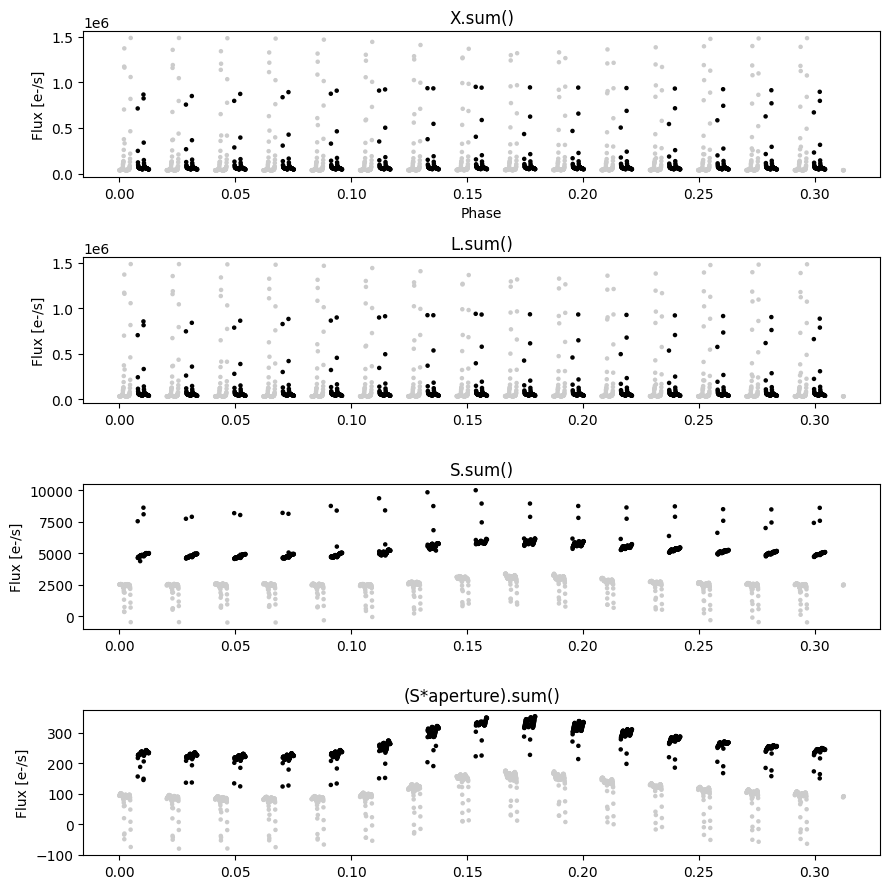

In [163]:
params = [
    dict(lbda=7e-3, tau=1000),
    dict(lbda=9e-3, tau=10000),
]

for idx in range(0,len(tpfs)):
    RPCA = aldaro.RobustPCA(
        max_iter=500,
        eps=1e-5,
        method='chambolle_pock',
        verbose=3,
        **params[idx],
    )
    print(RPCA)

    RPCA.fit(tpfs[idx])
    L, S = RPCA.transform()
    fig, axs, anim = RPCA.plot_result(
        tpfs[idx], L, S,
        animate=True,
        # pcolormesh_kwargs=dict(vmin=np.min([S]), vmax=np.max([S])),
        func_animation_kwargs=dict(repeat=False, frames=range(0,tpfs[idx].shape[0],50))
    )

    print(L.shape, S.shape, tpfs[idx].shape)

    #plot result as LCs
    fig = plt.figure(figsize=(9,9))
    ax1 = fig.add_subplot(411)
    ax2 = fig.add_subplot(412)
    ax3 = fig.add_subplot(413)
    ax4 = fig.add_subplot(414)
    ax1.set_title(f'X.sum()')
    ax2.set_title(f'L.sum()')
    ax3.set_title(f'S.sum()')
    ax4.set_title(f'(S*aperture).sum()')
    ax1.scatter(times[idx]%df_targets["period"][idx], tpfs[idx].sum(axis=(1,2)),c=sectors[idx], s=5, cmap="nipy_spectral")
    ax2.scatter(times[idx]%df_targets["period"][idx], L.sum(axis=(1,2)),        c=sectors[idx], s=5, cmap="nipy_spectral")
    ax3.scatter(times[idx]%df_targets["period"][idx], S.sum(axis=(1,2)),        c=sectors[idx], s=5, cmap="nipy_spectral")

    #applying aperture    
    AP = alprph.Aperture(tpfs[0].shape[1:], npixels=1)
    ap = AP.lp_aperture(radius=2, p=2).reshape(1,*tpfs[0].shape[1:])
    ax4.scatter(times[idx]%df_targets["period"][idx], (S*ap).sum(axis=(1,2)),   c=sectors[idx], s=5, cmap="nipy_spectral")

    ax1.set_xlabel('Phase')
    # ax2.set_xlabel('Phase')
    # ax3.set_xlabel('Phase')
    # ax4.set_xlabel('Phase')
    ax1.set_ylabel('Flux [e-/s]')
    ax2.set_ylabel('Flux [e-/s]')
    ax3.set_ylabel('Flux [e-/s]')
    ax4.set_ylabel('Flux [e-/s]')

    fig.tight_layout()

    fig.savefig(f"../_gfx/rpca_{df_targets['name'][idx]}_{RPCA.method}.png")
    anim.save(  f"../_gfx/rpca_{df_targets['name'][idx]}_{RPCA.method}.gif")
plt.show()
